# Evaluate FCM as a Method for Classification from Few Examples
This is done on Classifier and Agent representations.

In [1]:
import os
import numpy as np;
import matplotlib.pyplot as plt
from scipy import misc
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
from itertools import combinations 
import pandas as pd
import sklearn
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
path = '../../Results/TowerTraining/BalancedTestSet/'
figurePath = '../../Results/TowerTraining/Figures/AgentRewardComparisonsAdaTH/ReviewFigures/'
saveFigs = True
figureFormat = '.png'#'.eps'
dpi = 100 #300 for production

encInt = np.load(path + 'encInt.npy')
encC = np.load(path + 'encC.npy')
ClassOut = np.load(path + 'outClass.npy')
classifier_stats = np.load(figurePath+'classifier_stats.npy',allow_pickle='TRUE').item()

y = np.load(path + 'labels.npy')
obs = np.load(path + 'obs.npy')

### Apply Adaptive Threshold

In [3]:
c1ActTH = np.mean(encInt, axis = 0)
CActTH = np.mean(encC, axis = 0)

encInt = np.array(np.abs(encInt) > np.abs(c1ActTH),dtype=int)
encC = np.array(np.abs(encC) > np.abs(CActTH),dtype=int)

### Helper Methods

In [4]:
def getEdges(encodings):
    TH = 0.5
    comb = combinations(np.linspace(0,encodings.shape[1]-1,encodings.shape[1]), 2)
    c = list(comb)
    edges = np.zeros(len(c))  

    for i in range(encodings.shape[0]):
        for n in range(len(c)):
            a = int(c[n][0])
            b = int(c[n][1])
            if (encodings[i][a]>TH) & (encodings[i][b]>TH):
                edges[n] = edges[n]+1
    return edges,c

def learnConcept(examples, name, pattern_complexity,normalize = False):
    e,c = getEdges(examples)
    strongest = e.argsort()[-pattern_complexity:][::-1]
    strongest_combs = []
    strengths = []
    #print('Combinations:      Strength:')
    for s in strongest:
        #print(str(c[s]) + '        ' + str(int(e[s])))
        strongest_combs.append(c[s])
        strengths.append(int(e[s]))
    if normalize:
        strengths = strengths/np.sum(strengths)
    else:
        strengths = np.array(strengths)/examples.shape[0]
    return strongest_combs, strengths

def learnConceptNoPC(examples,normalize = False):
    e,c = getEdges(examples)
    strongest_combs = []
    for i,s in enumerate(e):
        if s >= np.max(e):#examples.shape[0]-2:
            strongest_combs.append(c[i])
    print(strongest_combs)
    strengths = np.ones(len(strongest_combs))*1/len(strongest_combs)
    return strongest_combs, strengths


def getActsLogic(neuronCombs, strengths, data, class_TH):
    patternOn = np.zeros(data.shape[0])
    for i,n in enumerate(neuronCombs):
        n1_act = (data[:,int(n[0])] > 0.5)
        n2_act = (data[:,int(n[1])] > 0.5)
        n_act = np.array(n1_act & n2_act, dtype=int) * strengths[i]
        patternOn = patternOn + n_act
    patternOn = (patternOn >= class_TH)
    return patternOn

def plotPatternActsLogic(patternOn, labels):
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(patternOn)
    plt.plot(labels/2)
    plt.xlim([0,labels.shape[0]])
    plt.ylim([0,1.1])
    plt.legend(['Pattern On', 'Label Present'])
    plt.yticks([])
    plt.xlabel('Frames')
    
    plt.subplot(1,2,2)
    c = plt.hist(patternOn + labels/2, bins = [0,0.5,1,1.5,2])
    plt.xticks([0.25,0.75,1.25,1.75],['TN', 'FN', 'FP','TP'])
    correct = np.round((c[0][0] + c[0][3])/labels.shape[0]*100,2)
    precision = np.round(c[0][3]/(c[0][3]+c[0][2])*100,2)# If L is predicted it is correct X% of time
    recall = np.round(c[0][3]/(c[0][3]+c[0][1])*100,2)# Correctly identifies X% of L
    plt.title('Correct: ' + str(correct) + '% Precision: ' + str(precision) + '% Recall: ' + str(recall) + '%')
    plt.show()
    
def plotCPR(cpr, THs):
    plt.clf()
    plt.figure(figsize=(15,5))
    plt.plot(cpr)
    plt.legend(['% Correct', 'Precision', 'Recall', 'CPR', 'F1'])
    plt.xticks(np.linspace(0,THs.shape[0]-1,THs.shape[0]),np.round(THs,2))
    plt.xlim([0,THs.shape[0]-1])
    plt.ylim([0,100])
    plt.xlabel('Threshold')
    plt.ylabel('Performance [Accuracy in %]')
    plt.show()
    
def getCPR(combs, weights, enc, labels, THs,pattern):
    cpr = np.zeros((THs.shape[0],5))
    for i,TH in enumerate(THs):
        if pattern=='single':
            patternOn = getSingleActsLogic(combs, weights, enc, class_TH=TH)
        elif pattern=='double':
            patternOn = getActsLogic(combs, weights, enc, class_TH=TH)
        elif pattern=='triple':
            patternOn = getTripletsActsLogic(combs, weights, enc, class_TH=TH)
        else:
            print('unknown pattern identifier.')
            break
        c = plt.hist(patternOn + labels/2, bins = [0,0.5,1,1.5,2])
        
        correct = np.round((c[0][0] + c[0][3])/labels.shape[0]*100,2)
        precision = np.round(c[0][3]/(c[0][3]+c[0][2])*100,2)# If L is predicted it is correct X% of time
        recall = np.round(c[0][3]/(c[0][3]+c[0][1])*100,2)# Correctly identifies X% of L
        f1score = np.round(2*(precision*recall/(precision+recall)),2)
        
        cpr[i] = np.array([correct,precision,recall,correct+precision+recall,f1score])
    plt.close()
    return np.nan_to_num(cpr)

def getCPR_THs(measure, labels, THs):
    cpr = np.zeros((THs.shape[0],5))
    for i,TH in enumerate(THs):
        classification = measure >= TH
        c = plt.hist(classification + labels/2, bins = [0,0.5,1,1.5,2])
        
        correct = np.round((c[0][0] + c[0][3])/labels.shape[0]*100,2)
        precision = np.round(c[0][3]/(c[0][3]+c[0][2])*100,2)# If L is predicted it is correct X% of time
        recall = np.round(c[0][3]/(c[0][3]+c[0][1])*100,2)# Correctly identifies X% of L
        f1score = np.round(2*(precision*recall/(precision+recall)),2)
        
        cpr[i] = np.array([correct,precision,recall,correct+precision+recall,f1score])
    plt.close()
    return np.nan_to_num(cpr)

def getCPR_no_THs(classification, labels):
    c = plt.hist(classification + labels/2, bins = [0,0.5,1,1.5,2])
        
    correct = np.round((c[0][0] + c[0][3])/labels.shape[0]*100,2)
    precision = np.round(c[0][3]/(c[0][3]+c[0][2])*100,2)# If L is predicted it is correct X% of time
    recall = np.round(c[0][3]/(c[0][3]+c[0][1])*100,2)# Correctly identifies X% of L
    f1score = np.round(2*(precision*recall/(precision+recall)),2)
        
    cpr = np.array([correct,precision,recall,correct+precision+recall,f1score])
    plt.clf()
    return np.nan_to_num(cpr)

def getConceptSubset(AllConceptExamples, numExp):
    subset = np.random.randint(0,AllConceptExamples.shape[0],numExp)
    trainExp = AllConceptExamples[subset]
    mask = np.ones(AllConceptExamples.shape, bool)
    mask[subset] = False
    testExp = AllConceptExamples[mask]
    return trainExp,  testExp

def getFP_FN(o,l):
    w = np.where(l!=o)
    FN = np.sum((o[w]==0)&(l[w]==1))/len(w[0])*100
    FP = np.sum((o[w]>0)&(l[w]==0))/len(w[0])*100
    return np.round(FP,3),np.round(FN,3)

def getAccPR(o,l):
    w = np.where(l!=o)
    trueP = np.sum((o==l)&(o==1))
    trueN = np.sum((o==l)&(o==0))
    falseP = np.sum((o[w]>0)&(l[w]==0))
    falseN = np.sum((o[w]==0)&(l[w]==1))
    Acc = (trueP+trueN)/len(o)*100
    Precision = trueP/(trueP+falseP)*100
    Recall = trueP/(trueP+falseN)*100
    return np.round(Acc,3),np.round(Precision,3),np.round(Recall,3),[trueP,trueN,falseP,falseN]

def printStats(out, labels):
    print('Accuracy: '+str(np.mean(out == labels)*100)+'%')
    print('Everything correct in '+str(np.sum(np.mean(out == labels,axis=1)==1.0)/len(labels)*100)+'%')
    print('Correct Door in '+str(np.round(np.mean(np.array(labels)[:,0]==out[:,0])*100,3))+'%')

    AccND,PND,RND,NDA = getAccPR((out[:,0]==0).astype(int),(labels[:,0]==0).astype(int))
    print('     No Door - Acc: '+str(AccND)+'% Precision: '+str(PND)+'% Recall: '+str(RND)+'%  |  TP,TN,FP,FN: '+str(NDA))

    AccLD,PLD,RLD,LDA = getAccPR((out[:,0]==1).astype(int),(labels[:,0]==1).astype(int))
    print('     Level Door - Acc: '+str(AccLD)+'% Precision: '+str(PLD)+'% Recall: '+str(RLD)+'%  |  TP,TN,FP,FN: '+str(LDA))

    AccGD,PGD,RGD,GDA = getAccPR((out[:,0]==2).astype(int),(labels[:,0]==2).astype(int))
    print('     Green Door - Acc: '+str(AccGD)+'% Precision: '+str(PGD)+'% Recall: '+str(RGD)+'%  |  TP,TN,FP,FN: '+str(GDA))

    AccKD,PKD,RKD,KDA = getAccPR((out[:,0]==3).astype(int),(labels[:,0]==3).astype(int))
    print('     Key Door - Acc: '+str(AccKD)+'% Precision: '+str(PKD)+'% Recall: '+str(RKD)+'%  |  TP,TN,FP,FN: '+str(KDA))

    AccOD,POD,ROD,ODA = getAccPR((out[:,0]==4).astype(int),(labels[:,0]==4).astype(int))
    print('     Other Door - Acc: '+str(AccOD)+'% Precision: '+str(POD)+'% Recall: '+str(ROD)+'%  |  TP,TN,FP,FN: '+str(ODA))

    AccK,PK,RK,KA = getAccPR(out[:,1],np.array(labels)[:,1])
    print('Correct Key in '+str(AccK)+'% - Precision: '+
          str(PK)+'% Recall: '+str(RK)+'%  |  TP,TN,FP,FN: '+str(KA))

    AccO,PO,RO,OA = getAccPR(out[:,2],np.array(labels)[:,2])
    print('Correct Orb in '+str(AccO)+'% - Precision: '+
          str(PO)+'% Recall: '+str(RO)+'%  |  TP,TN,FP,FN: '+str(OA))
    
def getStats(out, labels):

    AccND,PND,RND,NDA = getAccPR((out[:,0]==0).astype(int),(labels[:,0]==0).astype(int))
    
    AccLD,PLD,RLD,LDA = getAccPR((out[:,0]==1).astype(int),(labels[:,0]==1).astype(int))

    AccGD,PGD,RGD,GDA = getAccPR((out[:,0]==2).astype(int),(labels[:,0]==2).astype(int))

    AccKD,PKD,RKD,KDA = getAccPR((out[:,0]==3).astype(int),(labels[:,0]==3).astype(int))

    AccOD,POD,ROD,ODA = getAccPR((out[:,0]==4).astype(int),(labels[:,0]==4).astype(int))

    AccK,PK,RK,KA = getAccPR(out[:,1],np.array(labels)[:,1])

    AccO,PO,RO,OA = getAccPR(out[:,2],np.array(labels)[:,2])
    
    precisions = np.nan_to_num(np.array([PND, PLD, PGD, PKD, POD, PK, PO]))
    recalls = np.nan_to_num(np.array([RND, RLD, RGD, RKD, ROD, RK, RO]))
    f1scores = np.nan_to_num(np.round(2*(precisions*recalls/(precisions+recalls)),2))
    
    stats = {'Accuracy': np.mean(out == labels)*100,
            'Accuracies': np.array([AccND, AccLD, AccGD, AccKD, AccOD, AccK, AccO]),
            'Precisions': precisions,
            'Recalls': recalls,
            'F1Scores': f1scores}
    return stats

def plotTHAcc(stats):
    palette = sns.color_palette("pastel", n_colors=7)
    plt.figure(figsize=(10,5))
    all_accs = []
    for i,c in enumerate(stats):
        plt.plot(c['CPR_Test'][:,0], c=palette[i])
        all_accs.append(c['CPR_Test'][:,0])
    plt.plot(np.mean(all_accs,axis=0),lw=5,c='black')
    plt.legend(['Level Door', 'Green Door', 'Key Door', 'Other Door', 'Key', 'Orb','Avg'])
    plt.xticks(np.linspace(0,20,21),np.round(np.linspace(0,1,21),2))


### Hyperparameters

In [5]:
to_learn = ['Level Door', 'Green Door', 'Key Door', 'Other Door', 'Key', 'Orb']#'No Door', 
concept_def = [y[:,0]==1, y[:,0]==2, y[:,0]==3, y[:,0]==4, y[:,1]==1, y[:,2]==1]#y[:,0]==0, 
numExp = 6
pattern_complexity = 10

### The Different Concept Extraction Methods
#### FCM (Pairs)

In [6]:
def LearnAllConcepts(numExp, pattern_complexity, encoding, to_learn, concept_def):
    allConcepts = []
        
    for i, concept in enumerate(to_learn):
        learnExamples, testExamples = getConceptSubset(np.where(concept_def[i])[0], numExp)

        examples = encoding[learnExamples]
        labels_test = concept_def[i]

        if pattern_complexity > 0:
            combs, weights = learnConcept(examples, 'x', pattern_complexity=pattern_complexity,normalize=True)
        else:
            combs, weights = learnConceptNoPC(examples)
        
        
        true_exp = np.where(labels_test==True)[0]
        false_exp = np.where(labels_test==False)[0]
        np.random.shuffle(false_exp)
        balanced_exp = np.append(true_exp,false_exp[:true_exp.shape[0]])

        cpr_train = getCPR(combs, weights, examples, np.ones(examples.shape[0]), np.linspace(0,1,21),pattern='double')
        cpr_test = getCPR(combs, weights, encoding[balanced_exp], labels_test[balanced_exp], np.linspace(0,1,21),pattern='double')

        ConceptStats = {'Concept':concept,
                     'Examples': learnExamples,
                   'TestExamples': testExamples,
                     'ExamplesEnc': examples,
                     'Combinations': combs,
                     'Weights': weights,
                     'CPR_Train': cpr_train,
                     'CPR_Test': cpr_test}

        allConcepts.append(ConceptStats)
    return allConcepts


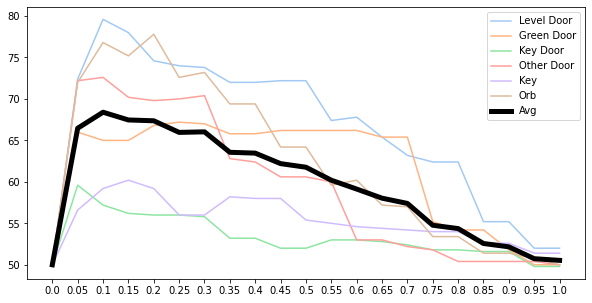

In [7]:
allConceptsPair = LearnAllConcepts(numExp, pattern_complexity, encInt, to_learn, concept_def)
plotTHAcc(allConceptsPair)

#### Single Activations

In [8]:
def learnSingleConcept(examples, pattern_complexity,normalize = False):
    neuronActs = np.sum(examples,axis=0)
    strongest = neuronActs.argsort()[-pattern_complexity:][::-1]
    strongest_N = []
    strengths = []
    for s in strongest:
        #print(str(s) + '        ' + str(int(neuronActs[s])))
        strongest_N.append(s)
        strengths.append(int(neuronActs[s]))#/examples.shape[0])
    if normalize:
        strengths = strengths/np.sum(strengths)
    else:
        strengths = np.array(strengths)/examples.shape[0]
    return strongest_N, strengths

def learnSingleConceptNoPC(examples,normalize = False):
    neuronActs = np.sum(examples,axis=0)
    #strongest = neuronActs.argsort()[-pattern_complexity:][::-1]
    strongest_N = []
    strengths = []
    for i,n in enumerate(neuronActs):
        #print(str(s) + '        ' + str(int(neuronActs[s])))
        if n >= np.max(neuronActs):
            strongest_N.append(i)
    print(strongest_N)
    weights = np.ones(len(strongest_N))*1/len(strongest_N)
    return strongest_N, weights

def getSingleActsLogic(neurons, strengths, data, class_TH):
    #strengths = strengths/np.max(strengths)
    patternOn = np.zeros(data.shape[0])
    for i,n in enumerate(neurons):
        n1_act = (data[:,int(n)] > 0.5)
        n_act = np.array(n1_act, dtype=int) * strengths[i]
        #print(n_act)
        patternOn = patternOn + n_act
    '''print('pattern on: ' + str(patternOn))
    print('Max: ' + str(np.max(patternOn))[:4])
    print('Min: ' + str(np.min(patternOn)))
    print('Mean: ' + str(np.mean(patternOn)))
    print('Median: ' + str(np.median(patternOn)))'''
    #plt.hist(patternOn)
    patternOn = (patternOn >= class_TH)#np.array(neuronCombs).shape[0]-1)
    return patternOn

def LearnAllSingleConcepts(numExp, pattern_complexity, encoding, to_learn, concept_def):
    allConcepts = []
        
    for i, concept in enumerate(to_learn):
        learnExamples, testExamples = getConceptSubset(np.where(concept_def[i])[0], numExp)

        examples = encoding[learnExamples]
        labels_test = concept_def[i]

        if pattern_complexity > 0:
            combs, weights = learnSingleConcept(examples, pattern_complexity=pattern_complexity,normalize=True)
        else:
            combs, weights = learnSingleConceptNoPC(examples)
        
        true_exp = np.where(labels_test==True)[0]
        false_exp = np.where(labels_test==False)[0]
        np.random.shuffle(false_exp)
        balanced_exp = np.append(true_exp,false_exp[:true_exp.shape[0]])

        cpr_train = getCPR(combs, weights, examples, np.ones(examples.shape[0]), np.linspace(0,1,21),pattern='single')
        cpr_test = getCPR(combs, weights, encoding[balanced_exp], labels_test[balanced_exp], np.linspace(0,1,21),pattern='single')
        
        ConceptStats = {'Concept':concept,
                     'Examples': learnExamples,
                   'TestExamples': testExamples,
                     'ExamplesEnc': examples,
                     'Combinations': combs,
                     'Weights': weights,
                     'CPR_Train': cpr_train,
                     'CPR_Test': cpr_test}

        allConcepts.append(ConceptStats)
    return allConcepts

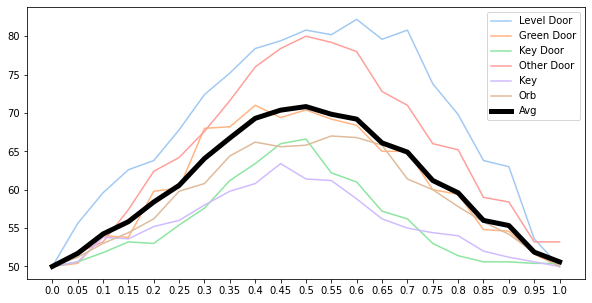

In [9]:
allConceptsSingle = LearnAllSingleConcepts(numExp, pattern_complexity, encC, to_learn, concept_def)
plotTHAcc(allConceptsSingle)

#### Triplet Activations

In [10]:
def getTriplets(encodings):
    TH = 0.5
    comb = combinations(np.linspace(0,encodings.shape[1]-1,encodings.shape[1]), 3)
    c = list(comb)
    triplets = np.zeros(len(c))

    for i in range(encodings.shape[0]):
        for n in range(len(c)):
            Na = int(c[n][0])
            Nb = int(c[n][1])
            Nc = int(c[n][2])
            if (encodings[i][Na]>TH) & (encodings[i][Nb]>TH) & (encodings[i][Nc]>TH):
                triplets[n] = triplets[n]+1
    return triplets,c

def learnTripletConcept(examples, pattern_complexity,normalize = False):
    t,c = getTriplets(examples)
    strongest = t.argsort()[-pattern_complexity:][::-1]
    strongest_combs = []
    strengths = []
    #print('Combinations:      Strength:')
    for s in strongest:
        #print(str(c[s]) + '        ' + str(int(t[s])))
        strongest_combs.append(c[s])
        strengths.append(int(t[s]))
    if normalize:
        strengths = strengths/np.sum(strengths)
    else:
        strengths = np.array(strengths)/examples.shape[0]
    return strongest_combs, strengths


def getTripletsActsLogic(neuronCombs, strengths, data, class_TH):
    patternOn = np.zeros(data.shape[0])
    for i,n in enumerate(neuronCombs):
        n1_act = (data[:,int(n[0])] > 0.5)
        n2_act = (data[:,int(n[1])] > 0.5)
        n3_act = (data[:,int(n[2])] > 0.5)
        n_act = np.array(n1_act & n2_act & n3_act, dtype=int) * strengths[i]
        patternOn = patternOn + n_act
    patternOn = (patternOn >= class_TH)
    return patternOn

def LearnAllTripletConcepts(numExp, pattern_complexity, encoding, to_learn, concept_def):
    allConcepts = []
        
    for i, concept in enumerate(to_learn):
        learnExamples, testExamples = getConceptSubset(np.where(concept_def[i])[0], numExp)

        examples = encoding[learnExamples]
        labels_test = concept_def[i]

        combs, weights = learnTripletConcept(examples, pattern_complexity=pattern_complexity,normalize=True)
        
        true_exp = np.where(labels_test==True)[0]
        false_exp = np.where(labels_test==False)[0]
        np.random.shuffle(false_exp)
        balanced_exp = np.append(true_exp,false_exp[:true_exp.shape[0]])

        cpr_train = getCPR(combs, weights, examples, np.ones(examples.shape[0]), np.linspace(0,1,21),pattern='triple')
        cpr_test = getCPR(combs, weights, encoding[balanced_exp], labels_test[balanced_exp], np.linspace(0,1,21),pattern='triple')

        ConceptStats = {'Concept':concept,
                     'Examples': learnExamples,
                     'Combinations': combs,
                     'Weights': weights,
                     'CPR_Train': cpr_train,
                     'CPR_Test': cpr_test}

        allConcepts.append(ConceptStats)
    return allConcepts

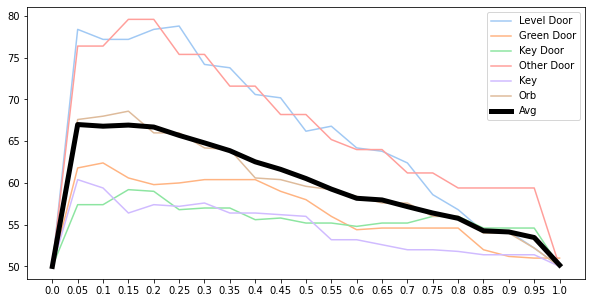

In [308]:
allConceptsTriplet = LearnAllTripletConcepts(numExp, pattern_complexity, encC, to_learn, concept_def)
plotTHAcc(allConceptsTriplet)

#### SVM

In [11]:
def LearnAllConceptsSVM(numExp, encoding, to_learn, concept_def):
    allConcepts = []
        
    for i, concept in enumerate(to_learn):
        learnExamples, testExamples = getConceptSubset(np.where(concept_def[i])[0], numExp)
        learnExamplesNeg, _ = getConceptSubset(np.where(np.logical_not(concept_def[i]))[0], numExp)

        examples = encoding[learnExamples]
        examplesNeg = encoding[learnExamplesNeg]
        labels_test = concept_def[i]

        clf_linear = svm.SVC(kernel='linear')
        clf_linear.fit(np.concatenate([examples,examplesNeg]), np.concatenate([np.ones(examples.shape[0]),np.zeros(examplesNeg.shape[0])]))
        out_linear = clf_linear.predict(encoding)
        
        true_exp = np.where(labels_test==True)[0]
        false_exp = np.where(labels_test==False)[0]
        np.random.shuffle(false_exp)
        balanced_exp = np.append(true_exp,false_exp[:true_exp.shape[0]])

        cpr_test = getCPR_no_THs(out_linear[balanced_exp], labels_test[balanced_exp])

        ConceptStats = {'Concept':concept,
                     'Examples': learnExamples,
                     'CPR_Test': cpr_test}

        allConcepts.append(ConceptStats)
    return allConcepts

#### Cosine Similarity

In [12]:
def LearnAllConceptsCosineSim(numExp, encoding, to_learn, concept_def):
    allConcepts = []
        
    for i, concept in enumerate(to_learn):
        learnExamples, testExamples = getConceptSubset(np.where(concept_def[i])[0], numExp)

        examples = encoding[learnExamples]
        labels_test = concept_def[i]

        centroid = np.mean(examples, axis=0)
        cosineSims = sklearn.metrics.pairwise.cosine_similarity(centroid.reshape(1, -1), encoding)[0]
        #classification = cosineSims >= TH
        
        true_exp = np.where(labels_test==True)[0]
        false_exp = np.where(labels_test==False)[0]
        np.random.shuffle(false_exp)
        balanced_exp = np.append(true_exp,false_exp[:true_exp.shape[0]])

        cpr_test = getCPR_THs(cosineSims[balanced_exp], labels_test[balanced_exp],np.linspace(0,1,21))

        ConceptStats = {'Concept':concept,
                     'Examples': learnExamples,
                     'CPR_Test': cpr_test}

        allConcepts.append(ConceptStats)
    return allConcepts

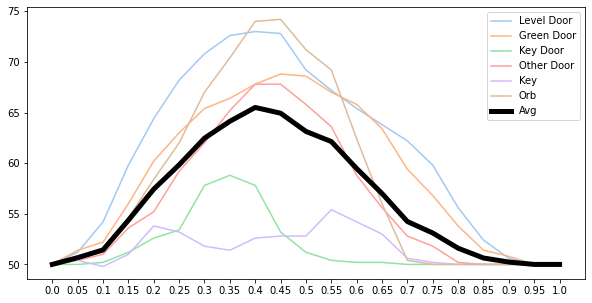

In [13]:
allConceptsCosSim = LearnAllConceptsCosineSim(5, encInt, to_learn, concept_def)
plotTHAcc(allConceptsCosSim)

#### Graph Edit Distance
Takes too long

In [14]:
# import networkx as nx
# from itertools import combinations
# def makeGraph(encoding, combinations):
#     c = list(combinations) 
#     G = nx.Graph()

#     for n in range(len(c)):
#         a = int(c[n][0])
#         b = int(c[n][1])
#         if (encoding[a]>0.5) & (encoding[b]>0.5):
#             G.add_edge(str(int(c[n][0])),str(int(c[n][1])),weight=1)
#     return G

In [15]:
# comb = combinations(np.linspace(0,255,256), 2)
# g = makeGraph(encC[0], comb)
# encMean = np.mean(encC[:5],axis=0)
# gMean = makeGraph(encMean, comb)

# nx.graph_edit_distance(g, gMean)

#### Decision Tree

In [13]:

def LearnAllConceptsDT(numExp, encoding, to_learn, concept_def):
    allConcepts = []
        
    for i, concept in enumerate(to_learn):
        learnExamples, testExamples = getConceptSubset(np.where(concept_def[i])[0], numExp)
        learnExamplesNeg, _ = getConceptSubset(np.where(np.logical_not(concept_def[i]))[0], numExp)

        examples = encoding[learnExamples]
        examplesNeg = encoding[learnExamplesNeg]
        labels_test = concept_def[i]

        clf = DecisionTreeClassifier(random_state=0)
        clf.fit(np.concatenate([examples,examplesNeg]), np.concatenate([np.ones(examples.shape[0]),np.zeros(examplesNeg.shape[0])]))
        out_linear = clf.predict(encoding)
        
        true_exp = np.where(labels_test==True)[0]
        false_exp = np.where(labels_test==False)[0]
        np.random.shuffle(false_exp)
        balanced_exp = np.append(true_exp,false_exp[:true_exp.shape[0]])

        cpr_test = getCPR_no_THs(out_linear[balanced_exp], labels_test[balanced_exp])

        ConceptStats = {'Concept':concept,
                     'Examples': learnExamples,
                     'CPR_Test': cpr_test}

        allConcepts.append(ConceptStats)
    return allConcepts

In [52]:
allConceptsDT = LearnAllConceptsDT(numExp//2, encC, to_learn, concept_def)

<Figure size 432x288 with 0 Axes>

#### PCA + Linear Regression

In [14]:
def LearnAllConceptsLR(numExp, encoding, to_learn, concept_def,pca=True):
    allConcepts = []
        
    for i, concept in enumerate(to_learn):
        learnExamples, testExamples = getConceptSubset(np.where(concept_def[i])[0], numExp)
        learnExamplesNeg, _ = getConceptSubset(np.where(np.logical_not(concept_def[i]))[0], numExp)

        examples = encoding[learnExamples]
        examplesNeg = encoding[learnExamplesNeg]
        labels_test = concept_def[i]

        pca = PCA(n_components=2)
        x = np.concatenate([examples,examplesNeg])
        pca.fit(x)
        lowdim = pca.transform(x)

        clf = LinearRegression()
        if pca:
            clf.fit(lowdim, np.concatenate([np.ones(examples.shape[0]),np.zeros(examplesNeg.shape[0])]))
            out_linear = clf.predict(pca.transform(encoding))
        else:
            clf.fit(np.concatenate([examples,examplesNeg]), np.concatenate([np.ones(examples.shape[0]),np.zeros(examplesNeg.shape[0])]))
            out_linear = clf.predict(encoding)
        
        true_exp = np.where(labels_test==True)[0]
        false_exp = np.where(labels_test==False)[0]
        np.random.shuffle(false_exp)
        balanced_exp = np.append(true_exp,false_exp[:true_exp.shape[0]])

        cpr_test = getCPR_no_THs(out_linear[balanced_exp]>=0.5, labels_test[balanced_exp])

        ConceptStats = {'Concept':concept,
                     'Examples': learnExamples,
                     'CPR_Test': cpr_test}

        allConcepts.append(ConceptStats)
    return allConcepts

In [19]:
allConceptsLR = LearnAllConceptsLR(numExp//2, encC, to_learn, concept_def)
#allConceptsLR

<Figure size 432x288 with 0 Axes>

## Experiments

### Run 100x for all Conditions
#### Classifier

In [19]:
numRuns = 100 # 15min for 2 -> 750min (12.5hrs) for 100
PatternStats_C = pd.DataFrame(columns = {'Concept','Encoding','Pattern','Pattern Complexity', 'Examples','NumExp','TH', 
                                        'Accuracy', 'Precision', 'Recall','CPR','F1Score'})
# Setting numExp to 6 (default=5) to be comparable with SVM with 3 positive and 3 negative examples
# Replaced pattern_complexity (default=10) with numbers to compensate for possibly more neurons involved in concept definition
numExpComp = 6
PCComp = 10
numNStats = []
for i in range(numRuns):
    
    print(str(i) + ": Single")
    allConceptsSingle = LearnAllSingleConcepts(numExpComp, PCComp, encC, to_learn, concept_def) # 12 neurons
    print(str(i) + ": Double")
    allConcepts = LearnAllConcepts(numExpComp, PCComp, encC, to_learn, concept_def) # 6*2 neurons = 12
    numNStats.append(np.unique(np.array(allConcepts[0]['Combinations']).flatten()).shape[0])
    print(str(i) + ": Triple")
    #allConceptsTriplet = LearnAllTripletConcepts(numExpComp, PCComp, encC, to_learn, concept_def) # 4*3 neurons = 12
    print(str(i) + ": SVM")
    allConceptsSVM = LearnAllConceptsSVM(numExpComp//2, encC, to_learn, concept_def) # 3 pos and 3 neg = 6 exp
    print(str(i) + ": Cos Sim")
    allConceptsCosSim = LearnAllConceptsCosineSim(numExpComp, encC, to_learn, concept_def) # can look at all neurons
    print(str(i) + ": DT")
    allConceptsDT = LearnAllConceptsDT(numExpComp//2, encC, to_learn, concept_def) # 3 pos and 3 neg = 6 exp
    print(str(i) + ": LR")
    allConceptsLR = LearnAllConceptsLR(numExpComp//2, encC, to_learn, concept_def,False) # 3 pos and 3 neg = 6 exp
    print(str(i) + ": LR + PCA5")
    allConceptsLRPCA = LearnAllConceptsDT(numExpComp//2, encC, to_learn, concept_def) # 3 pos and 3 neg = 6 exp
    for c in allConceptsSingle:
        BestTH = c['CPR_Test'][11]
        PatternStats_C = PatternStats_C.append({'Concept': c['Concept'],'Encoding':'Classifier','Pattern':'Single',
                                                        'Pattern Complexity':PCComp, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                                    'TH': 0.55,
                                                                    'Accuracy': BestTH[0],
                                                                    'Precision': BestTH[1],
                                                                    'Recall': BestTH[2],
                                                                    'CPR':BestTH[3],'F1Score':BestTH[4]},ignore_index=True)
        
    for c in allConcepts:
        BestTH = c['CPR_Test'][5]
        PatternStats_C = PatternStats_C.append({'Concept': c['Concept'],'Encoding':'Classifier','Pattern':'Double',
                                                        'Pattern Complexity':PCComp, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                                    'TH': 0.25,
                                                                    'Accuracy': BestTH[0],
                                                                    'Precision': BestTH[1],
                                                                    'Recall': BestTH[2],
                                                                    'CPR':BestTH[3],'F1Score':BestTH[4]},ignore_index=True)

    for c in allConcepts:#Triplet:
        BestTH = c['CPR_Test'][1]
        PatternStats_C = PatternStats_C.append({'Concept': c['Concept'],'Encoding':'Classifier','Pattern':'Triplet',
                                                        'Pattern Complexity':PCComp, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                                    'TH': 0.05,
                                                                    'Accuracy': BestTH[0],
                                                                    'Precision': BestTH[1],
                                                                    'Recall': BestTH[2],
                                                                    'CPR':BestTH[3],'F1Score':BestTH[4]},ignore_index=True)
    for c in allConceptsCosSim:
        BestTH = c['CPR_Test'][12]
        PatternStats_C = PatternStats_C.append({'Concept': c['Concept'],'Encoding':'Classifier','Pattern':'Cosine Similarity',
                                                            'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                'TH': 0.6,'Accuracy': BestTH[0],
                                                                    'Precision': BestTH[1],
                                                                    'Recall': BestTH[2],
                                                                    'CPR':BestTH[3],'F1Score':BestTH[4]},ignore_index=True)
    for c in allConceptsSVM:
        PatternStats_C = PatternStats_C.append({'Concept': c['Concept'],'Encoding':'Classifier','Pattern':'SVM',
                                                            'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                'TH': 0,
                                                'Accuracy': c['CPR_Test'][0], 'Precision': c['CPR_Test'][1],
                                                'Recall': c['CPR_Test'][2],'CPR':c['CPR_Test'][3],'F1Score':c['CPR_Test'][4]},ignore_index=True)
    
    for c in allConceptsDT:
        PatternStats_C = PatternStats_C.append({'Concept': c['Concept'],'Encoding':'Classifier','Pattern':'Decision Tree',
                                                            'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                'TH': 0,
                                                'Accuracy': c['CPR_Test'][0], 'Precision': c['CPR_Test'][1],
                                                'Recall': c['CPR_Test'][2],'CPR':c['CPR_Test'][3],'F1Score':c['CPR_Test'][4]},ignore_index=True)
    
    for c in allConceptsLR:
        PatternStats_C = PatternStats_C.append({'Concept': c['Concept'],'Encoding':'Classifier','Pattern':'Linear Regression',
                                                            'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                'TH': 0,
                                                'Accuracy': c['CPR_Test'][0], 'Precision': c['CPR_Test'][1],
                                                'Recall': c['CPR_Test'][2],'CPR':c['CPR_Test'][3],'F1Score':c['CPR_Test'][4]},ignore_index=True)

    # Worse than just linear regression
    # for c in allConceptsLRPCA:
    #     PatternStats_C = PatternStats_C.append({'Concept': c['Concept'],'Encoding':'Classifier','Pattern':'LR + PCA(2)',
    #                                                         'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
    #                                             'TH': 0,
    #                                             'Accuracy': c['CPR_Test'][0], 'Precision': c['CPR_Test'][1],
    #                                             'Recall': c['CPR_Test'][2],'CPR':c['CPR_Test'][3],'F1Score':c['CPR_Test'][4]},ignore_index=True)

0: Single
0: Double
0: Triple
0: SVM
0: Cos Sim
0: DT
0: LR
0: LR + PCA5
1: Single
1: Double
1: Triple
1: SVM
1: Cos Sim
1: DT
1: LR
1: LR + PCA5
2: Single
2: Double
2: Triple
2: SVM
2: Cos Sim
2: DT
2: LR
2: LR + PCA5
3: Single
3: Double
3: Triple
3: SVM
3: Cos Sim
3: DT
3: LR
3: LR + PCA5
4: Single
4: Double
4: Triple
4: SVM
4: Cos Sim
4: DT
4: LR
4: LR + PCA5
5: Single
5: Double
5: Triple
5: SVM
5: Cos Sim
5: DT
5: LR
5: LR + PCA5
6: Single
6: Double
6: Triple
6: SVM
6: Cos Sim
6: DT
6: LR
6: LR + PCA5
7: Single
7: Double
7: Triple
7: SVM
7: Cos Sim
7: DT
7: LR
7: LR + PCA5
8: Single
8: Double
8: Triple
8: SVM
8: Cos Sim
8: DT
8: LR
8: LR + PCA5
9: Single
9: Double
9: Triple
9: SVM
9: Cos Sim
9: DT
9: LR
9: LR + PCA5
10: Single
10: Double
10: Triple
10: SVM
10: Cos Sim
10: DT
10: LR
10: LR + PCA5
11: Single
11: Double
11: Triple
11: SVM
11: Cos Sim
11: DT
11: LR
11: LR + PCA5
12: Single
12: Double
12: Triple
12: SVM
12: Cos Sim
12: DT
12: LR
12: LR + PCA5
13: Single
13: Double
13: T

<Figure size 432x288 with 0 Axes>

In [228]:
np.mean(numNStats)

9.3

In [28]:
PatternStats_C.to_csv(figurePath+'ManyPatternStats_C_100Trip.csv')

In [21]:
PatternStats_Cx = pd.read_csv(figurePath + 'Final/ManyPatternStats_C_100Trip.csv')

In [22]:
PatternStats_Cmix = pd.concat([PatternStats_C[PatternStats_C['Pattern']!='Triplet'],PatternStats_Cx[PatternStats_Cx['Pattern']=='Triplet']])

In [25]:
PatternStats_C

,TH,Precision,Encoding,F1Score,CPR,NumExp,Examples,Recall,Concept,Accuracy,Pattern Complexity,Pattern
0,0.55,90.34,Classifier,81.84,248.54,6,"[539, 547, 542, 372, 539, 467]",74.8,Level Door,83.4,10,Single
1,0.55,67.92,Classifier,62.34,190.72,6,"[819, 727, 668, 736, 620, 837]",57.6,Green Door,65.2,10,Single
2,0.55,68.21,Classifier,51.37,170.41,6,"[858, 1033, 869, 1032, 946, 1039]",41.2,Key Door,61.0,10,Single
3,0.55,84.29,Classifier,76.96,233.89,6,"[1326, 1281, 1309, 1180, 1213, 1181]",70.8,Other Door,78.8,10,Single
4,0.55,71.26,Classifier,58.49,185.66,6,"[1085, 1060, 276, 251, 222, 297]",49.6,Key,64.8,10,Single
...,...,...,...,...,...,...,...,...,...,...,...,...
4195,0.00,63.58,Classifier,70.69,210.18,6,"[698, 834, 728]",79.6,Green Door,67.0,0,Linear Regression
4196,0.00,76.27,Classifier,63.23,198.87,6,"[1099, 906, 923]",54.0,Key Door,68.6,0,Linear Regression
4197,0.00,68.33,Classifier,64.12,194.93,6,"[1122, 1278, 1171]",60.4,Other Door,66.2,0,Linear Regression
4198,0.00,67.55,Classifier,73.91,220.35,6,"[348, 817, 223]",81.6,Key,71.2,0,Linear Regression


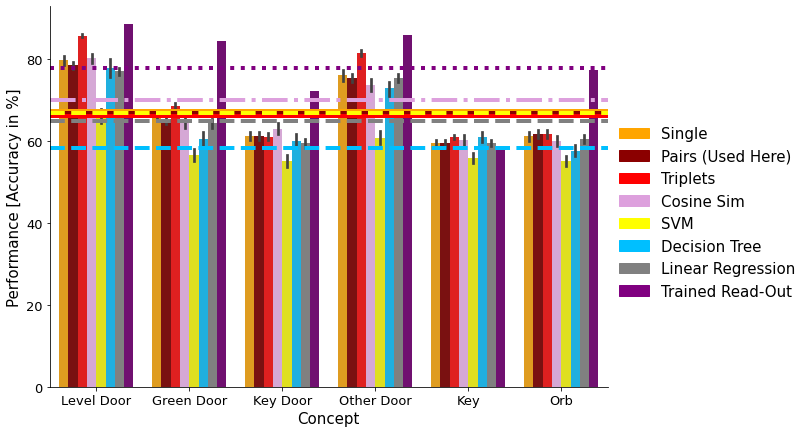

In [27]:
colors = ['orange','darkred','red','plum','yellow','deepskyblue','grey','purple']

plt.figure(figsize=(10,7))

data = PatternStats_Cmix
for i,c in enumerate(data['Concept'].unique()):
    data = data.append({'Concept': c,'Pattern':'Trained Read-Out','Encoding':'Classifier','Examples': 'all','NumExp':'all','TH': 0,'Accuracy': classifier_stats['Accuracies'][i+1],
                                                                            'Precision': classifier_stats['Precisions'][i+1],
                                                                            'Recall': classifier_stats['Recalls'][i+1],
                                                                            'CPR':0,'F1Score':classifier_stats['F1Scores'][i+1]},ignore_index=True)

ax1 = sns.barplot(data=data,x='Concept',y='Accuracy',hue='Pattern',palette=colors)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('Concept',fontsize=15)
plt.ylabel('Performance [Accuracy in %]',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim([-0.5,5.5])
legend_labels = ['Single','Pairs (Used Here)', 'Triplets','Cosine Sim','SVM','Decision Tree','Linear Regression','Trained Read-Out']
values = np.linspace(1,8,8)
patches = [ mpatches.Patch(color=colors[i], label=legend_labels[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.01, 0.7), loc=2, borderaxespad=0. ,
           title_fontsize=15,fontsize=15,frameon=False,ncol=1)

avgAlpha = 1
avgLW=4
SMean = np.mean(data[data['Pattern']=='Single']['Accuracy'])
plt.plot([-0.5,7],[SMean, SMean],color=colors[0],lw=avgLW,alpha=avgAlpha)

PMean = np.mean(data[data['Pattern']=='Double']['Accuracy'])
plt.plot([-0.5,7],[PMean, PMean],color=colors[1],lw=avgLW,alpha=avgAlpha)

TMean = np.mean(data[data['Pattern']=='Triplet']['Accuracy'])
plt.plot([-0.5,7],[TMean, TMean],color=colors[2],lw=avgLW,alpha=avgAlpha)

CosSimMean = np.mean(data[data['Pattern']=='Cosine Similarity']['Accuracy'])
plt.plot([-0.5,7],[CosSimMean, CosSimMean],color=colors[3],lw=avgLW,alpha=avgAlpha,ls='-.')

SVMMean = np.mean(data[data['Pattern']=='SVM']['Accuracy'])
plt.plot([-0.5,7],[SVMMean, SVMMean],color=colors[4],lw=avgLW,alpha=avgAlpha,ls='--')

DTMean = np.mean(data[data['Pattern']=='Decision Tree']['Accuracy'])
plt.plot([-0.5,7],[DTMean, DTMean],color=colors[5],lw=avgLW,alpha=avgAlpha,ls='--')

LRMean = np.mean(data[data['Pattern']=='Linear Regression']['Accuracy'])
plt.plot([-0.5,7],[LRMean, LRMean],color=colors[6],lw=avgLW,alpha=avgAlpha,ls='--')

#LRPCAMean = np.mean(data[data['Pattern']=='LR + PCA(2)']['Accuracy'])
#plt.plot([-0.5,7],[LRPCAMean, LRPCAMean],color=colors[7],lw=avgLW,alpha=avgAlpha,ls=':')

ClassOutMean = np.mean(classifier_stats['Accuracies'][1:])#exclude no door concept
plt.plot([-0.5,7],[ClassOutMean, ClassOutMean],color='purple',lw=avgLW,alpha=avgAlpha,ls=':')

#plt.text(1.9,79,'~7.900.000 Examples (35.000 unique), Fully-Supervised',fontsize=12)

plt.show() if not saveFigs else plt.savefig(figurePath+'ManyPattern_Comp_C_100Trip2' + figureFormat, bbox_inches='tight', dpi=dpi)

#### Agent

In [39]:
numRuns = 100 # 15min for 2 -> 750min (12.5hrs) for 100
PatternStats_A = pd.DataFrame(columns = {'Concept','Encoding','Pattern','Pattern Complexity', 'Examples','NumExp','TH', 
                                        'Accuracy', 'Precision', 'Recall','CPR','F1Score'})
# Setting numExp to 6 (default=5) to be comparable with SVM with 3 positive and 3 negative examples
# Replaced pattern_complexity (default=10) with numbers to compensate for possibly more neurons involved in concept definition
numExpComp = 6
PCComp = 10
numNStats = []
for i in range(numRuns):
    
    print(str(i) + ": Single")
    allConceptsSingle = LearnAllSingleConcepts(numExpComp, PCComp, encInt, to_learn, concept_def) # 12 neurons
    print(str(i) + ": Double")
    allConcepts = LearnAllConcepts(numExpComp, PCComp, encInt, to_learn, concept_def) # 6*2 neurons = 12
    numNStats.append(np.unique(np.array(allConcepts[0]['Combinations']).flatten()).shape[0])
    print(str(i) + ": Triple")
    #allConceptsTriplet = LearnAllTripletConcepts(numExpComp, PCComp, encInt, to_learn, concept_def) # 4*3 neurons = 12
    print(str(i) + ": SVM")
    allConceptsSVM = LearnAllConceptsSVM(numExpComp//2, encInt, to_learn, concept_def) # 3 pos and 3 neg = 6 exp
    print(str(i) + ": Cos Sim")
    allConceptsCosSim = LearnAllConceptsCosineSim(numExpComp, encInt, to_learn, concept_def) # can look at all neurons
    print(str(i) + ": DT")
    allConceptsDT = LearnAllConceptsDT(numExpComp//2, encInt, to_learn, concept_def) # 3 pos and 3 neg = 6 exp
    print(str(i) + ": LR")
    allConceptsLR = LearnAllConceptsLR(numExpComp//2, encInt, to_learn, concept_def,False) # 3 pos and 3 neg = 6 exp
    #print(str(i) + ": LR + PCA5")
    #allConceptsLRPCA = LearnAllConceptsDT(numExpComp//2, encInt, to_learn, concept_def) # 3 pos and 3 neg = 6 exp
    for c in allConceptsSingle:
        BestTH = c['CPR_Test'][8]
        PatternStats_A = PatternStats_A.append({'Concept': c['Concept'],'Encoding':'Agent','Pattern':'Single',
                                                        'Pattern Complexity':PCComp, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                                    'TH': 0.4,
                                                                    'Accuracy': BestTH[0],
                                                                    'Precision': BestTH[1],
                                                                    'Recall': BestTH[2],
                                                                    'CPR':BestTH[3],'F1Score':BestTH[4]},ignore_index=True)
        
    for c in allConcepts:
        BestTH = c['CPR_Test'][3]
        PatternStats_A = PatternStats_A.append({'Concept': c['Concept'],'Encoding':'Agent','Pattern':'Double',
                                                        'Pattern Complexity':PCComp, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                                    'TH': 0.15,
                                                                    'Accuracy': BestTH[0],
                                                                    'Precision': BestTH[1],
                                                                    'Recall': BestTH[2],
                                                                    'CPR':BestTH[3],'F1Score':BestTH[4]},ignore_index=True)

    for c in allConcepts:#Triplet:
        BestTH = c['CPR_Test'][1]
        PatternStats_A = PatternStats_A.append({'Concept': c['Concept'],'Encoding':'Agent','Pattern':'Triplet',
                                                        'Pattern Complexity':PCComp, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                                    'TH': 0.05,
                                                                    'Accuracy': BestTH[0],
                                                                    'Precision': BestTH[1],
                                                                    'Recall': BestTH[2],
                                                                    'CPR':BestTH[3],'F1Score':BestTH[4]},ignore_index=True)

    for c in allConceptsCosSim:
        BestTH = c['CPR_Test'][9]
        PatternStats_A = PatternStats_A.append({'Concept': c['Concept'],'Encoding':'Agent','Pattern':'Cosine Similarity',
                                                            'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                'TH': 0.45,'Accuracy': BestTH[0],
                                                                    'Precision': BestTH[1],
                                                                    'Recall': BestTH[2],
                                                                    'CPR':BestTH[3],'F1Score':BestTH[4]},ignore_index=True)
    for c in allConceptsSVM:
        PatternStats_A = PatternStats_A.append({'Concept': c['Concept'],'Encoding':'Agent','Pattern':'SVM',
                                                            'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                'TH': 0,
                                                'Accuracy': c['CPR_Test'][0], 'Precision': c['CPR_Test'][1],
                                                'Recall': c['CPR_Test'][2],'CPR':c['CPR_Test'][3],'F1Score':c['CPR_Test'][4]},ignore_index=True)

    for c in allConceptsDT:
        PatternStats_A = PatternStats_A.append({'Concept': c['Concept'],'Encoding':'Agent','Pattern':'Decision Tree',
                                                            'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                'TH': 0,
                                                'Accuracy': c['CPR_Test'][0], 'Precision': c['CPR_Test'][1],
                                                'Recall': c['CPR_Test'][2],'CPR':c['CPR_Test'][3],'F1Score':c['CPR_Test'][4]},ignore_index=True)
    
    for c in allConceptsLR:
        PatternStats_A = PatternStats_A.append({'Concept': c['Concept'],'Encoding':'Agent','Pattern':'Linear Regression',
                                                            'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
                                                'TH': 0,
                                                'Accuracy': c['CPR_Test'][0], 'Precision': c['CPR_Test'][1],
                                                'Recall': c['CPR_Test'][2],'CPR':c['CPR_Test'][3],'F1Score':c['CPR_Test'][4]},ignore_index=True)

    # for c in allConceptsLRPCA:
    #     PatternStats_A = PatternStats_A.append({'Concept': c['Concept'],'Encoding':'Agent','Pattern':'LR + PCA(2)',
    #                                                         'Pattern Complexity':0, 'Examples': c['Examples'],'NumExp':numExpComp,
    #                                             'TH': 0,
    #                                             'Accuracy': c['CPR_Test'][0], 'Precision': c['CPR_Test'][1],
    #                                             'Recall': c['CPR_Test'][2],'CPR':c['CPR_Test'][3],'F1Score':c['CPR_Test'][4]},ignore_index=True)

0: Single
0: Double
0: Triple
0: SVM
0: Cos Sim
0: DT
0: LR
1: Single
1: Double
1: Triple
1: SVM
1: Cos Sim
1: DT
1: LR
2: Single
2: Double
2: Triple
2: SVM
2: Cos Sim
2: DT
2: LR
3: Single
3: Double
3: Triple
3: SVM
3: Cos Sim
3: DT
3: LR
4: Single
4: Double
4: Triple
4: SVM
4: Cos Sim
4: DT
4: LR
5: Single
5: Double
5: Triple
5: SVM
5: Cos Sim
5: DT
5: LR
6: Single
6: Double
6: Triple
6: SVM
6: Cos Sim
6: DT
6: LR
7: Single
7: Double
7: Triple
7: SVM
7: Cos Sim
7: DT
7: LR
8: Single
8: Double
8: Triple
8: SVM
8: Cos Sim
8: DT
8: LR
9: Single
9: Double
9: Triple
9: SVM
9: Cos Sim
9: DT
9: LR
10: Single
10: Double
10: Triple
10: SVM
10: Cos Sim
10: DT
10: LR
11: Single
11: Double
11: Triple
11: SVM
11: Cos Sim
11: DT
11: LR
12: Single
12: Double
12: Triple
12: SVM
12: Cos Sim
12: DT
12: LR
13: Single
13: Double
13: Triple
13: SVM
13: Cos Sim
13: DT
13: LR
14: Single
14: Double
14: Triple
14: SVM
14: Cos Sim
14: DT
14: LR
15: Single
15: Double
15: Triple
15: SVM
15: Cos Sim
15: DT
15: L

<Figure size 432x288 with 0 Axes>

In [ ]:
np.mean(numNStats)

7.55

In [44]:
PatternStats_Amix.to_csv(figurePath+'ManyPatternStats_A_100Trip2.csv')

In [41]:
PatternStats_Ax = pd.read_csv(figurePath + 'Final/ManyPatternStats_A_100Trip.csv')

In [42]:
PatternStats_Amix = pd.concat([PatternStats_A[PatternStats_A['Pattern']!='Triplet'],PatternStats_Ax[PatternStats_Ax['Pattern']=='Triplet']])

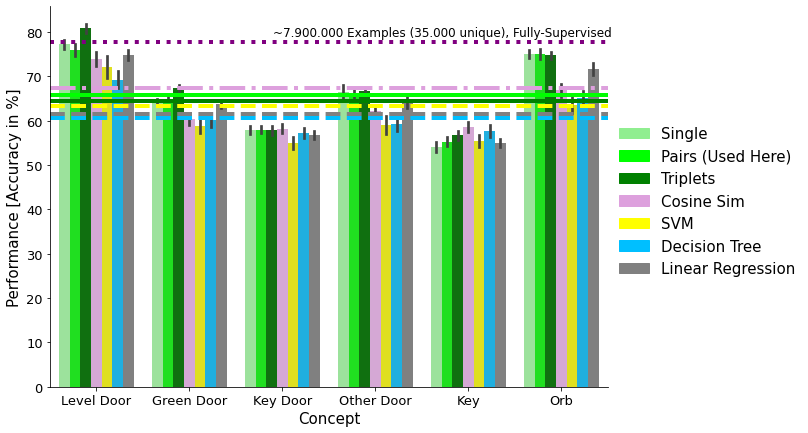

In [43]:
colors = ['lightgreen','lime','green','plum','yellow','deepskyblue','grey','purple']

plt.figure(figsize=(10,7))

data = PatternStats_Amix
ax1 = sns.barplot(data=data,x='Concept',y='Accuracy',hue='Pattern',palette=colors)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('Concept',fontsize=15)
plt.ylabel('Performance [Accuracy in %]',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim([-0.5,5.5])
legend_labels = ['Single','Pairs (Used Here)', 'Triplets','Cosine Sim','SVM','Decision Tree','Linear Regression']
values = np.linspace(1,7,7)
patches = [ mpatches.Patch(color=colors[i], label=legend_labels[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.01, 0.7), loc=2, borderaxespad=0. ,
           title_fontsize=15,fontsize=15,frameon=False,ncol=1)

avgAlpha = 1
avgLW=4
SMean = np.mean(data[data['Pattern']=='Single']['Accuracy'])
plt.plot([-0.5,7],[SMean, SMean],color=colors[0],lw=avgLW,alpha=avgAlpha)

PMean = np.mean(data[data['Pattern']=='Double']['Accuracy'])
plt.plot([-0.5,7],[PMean, PMean],color=colors[1],lw=avgLW,alpha=avgAlpha)

TMean = np.mean(data[data['Pattern']=='Triplet']['Accuracy'])
plt.plot([-0.5,7],[TMean, TMean],color=colors[2],lw=avgLW,alpha=avgAlpha)

CosSimMean = np.mean(data[data['Pattern']=='Cosine Similarity']['Accuracy'])
plt.plot([-0.5,7],[CosSimMean, CosSimMean],color=colors[3],lw=avgLW,alpha=avgAlpha,ls='-.')

SVMMean = np.mean(data[data['Pattern']=='SVM']['Accuracy'])
plt.plot([-0.5,7],[SVMMean, SVMMean],color=colors[4],lw=avgLW,alpha=avgAlpha,ls='--')

DTMean = np.mean(data[data['Pattern']=='Decision Tree']['Accuracy'])
plt.plot([-0.5,7],[DTMean, DTMean],color=colors[5],lw=avgLW,alpha=avgAlpha,ls='--')

LRMean = np.mean(data[data['Pattern']=='Linear Regression']['Accuracy'])
plt.plot([-0.5,7],[LRMean, LRMean],color=colors[6],lw=avgLW,alpha=avgAlpha,ls='--')

#LRPCAMean = np.mean(data[data['Pattern']=='LR + PCA(2)']['Accuracy'])
#plt.plot([-0.5,7],[LRPCAMean, LRPCAMean],color=colors[7],lw=avgLW,alpha=avgAlpha,ls=':')

ClassOutMean = np.mean(classifier_stats['Accuracies'][1:])#exclude no door concept
plt.plot([-0.5,7],[ClassOutMean, ClassOutMean],color='purple',lw=avgLW,alpha=avgAlpha,ls=':')

plt.text(1.9,79,'~7.900.000 Examples (35.000 unique), Fully-Supervised',fontsize=12)

plt.show()# if not saveFigs else plt.savefig(figurePath+'ManyPattern_Comp_A' + figureFormat, bbox_inches='tight', dpi=dpi)

## Both

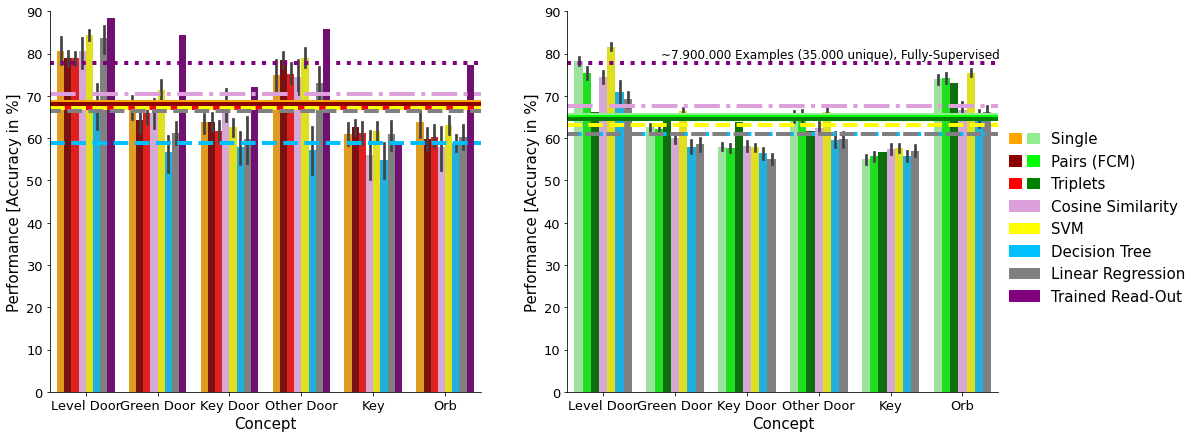

In [ ]:

colors = ['orange','darkred','red','plum','yellow','deepskyblue','grey','purple','lightgreen','lime','green']

plt.figure(figsize=(17,7))
plt.subplot(1,2,1)

data = PatternStats_C
for i,c in enumerate(data['Concept'].unique()):
    data = data.append({'Concept': c,'Pattern':'Trained Read-Out','Encoding':'Classifier','Examples': 'all','NumExp':'all','TH': 0,'Accuracy': classifier_stats['Accuracies'][i+1],
                                                                            'Precision': classifier_stats['Precisions'][i+1],
                                                                            'Recall': classifier_stats['Recalls'][i+1],
                                                                            'CPR':0,'F1Score':classifier_stats['F1Scores'][i+1]},ignore_index=True)

ax1 = sns.barplot(data=data,x='Concept',y='Accuracy',hue='Pattern',palette=colors)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('Concept',fontsize=15)
plt.ylabel('Performance [Accuracy in %]',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim([-0.5,5.5])
plt.ylim([0,90])
legend_labels = ['Single','Pairs (Used Here)', 'Triplets','Cosine Sim','SVM','Decision Tree','Linear Regression','Trained Read-Out']
values = np.linspace(1,8,8)
patches = [ mpatches.Patch(color=colors[i], label=legend_labels[i] ) for i in range(len(values)) ]
#plt.legend(handles=patches, bbox_to_anchor=(1.01, 0.7), loc=2, borderaxespad=0. ,
#           title_fontsize=15,fontsize=15,frameon=False,ncol=1)
ax1.get_legend().remove()

avgAlpha = 1
avgLW=4
SMean = np.mean(data[data['Pattern']=='Single']['Accuracy'])
plt.plot([-0.5,7],[SMean, SMean],color=colors[0],lw=avgLW,alpha=avgAlpha)

PMean = np.mean(data[data['Pattern']=='Double']['Accuracy'])
plt.plot([-0.5,7],[PMean, PMean],color=colors[1],lw=avgLW,alpha=avgAlpha)

TMean = np.mean(data[data['Pattern']=='Triplet']['Accuracy'])
plt.plot([-0.5,7],[TMean, TMean],color=colors[2],lw=avgLW,alpha=avgAlpha)

CosSimMean = np.mean(data[data['Pattern']=='Cosine Similarity']['Accuracy'])
plt.plot([-0.5,7],[CosSimMean, CosSimMean],color=colors[3],lw=avgLW,alpha=avgAlpha,ls='-.')

SVMMean = np.mean(data[data['Pattern']=='SVM']['Accuracy'])
plt.plot([-0.5,7],[SVMMean, SVMMean],color=colors[4],lw=avgLW,alpha=avgAlpha,ls='--')

DTMean = np.mean(data[data['Pattern']=='Decision Tree']['Accuracy'])
plt.plot([-0.5,7],[DTMean, DTMean],color=colors[5],lw=avgLW,alpha=avgAlpha,ls='--')

LRMean = np.mean(data[data['Pattern']=='Linear Regression']['Accuracy'])
plt.plot([-0.55,7],[LRMean, LRMean],color=colors[6],lw=avgLW,alpha=avgAlpha,ls='--')

ClassOutMean = np.mean(classifier_stats['Accuracies'][1:])#exclude no door concept
plt.plot([-0.5,7],[ClassOutMean, ClassOutMean],color='purple',lw=avgLW,alpha=avgAlpha,ls=':')

#plt.text(1.9,79,'~7.900.000 Examples (35.000 unique), Fully-Supervised',fontsize=12)

plt.subplot(1,2,2)

colors2 = np.append(colors[-3:],colors[3:-3])

data = PatternStats_A
ax1 = sns.barplot(data=data,x='Concept',y='Accuracy',hue='Pattern',palette=colors2)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('Concept',fontsize=15)
plt.ylabel('Performance [Accuracy in %]',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim([-0.5,5.5])
plt.ylim([0,90])
legend_labels = ['Single','Pairs (FCM)', 'Triplets','Cosine Similarity','SVM','Decision Tree','Linear Regression','Trained Read-Out']
values = np.linspace(1,7,7)
patches = []
for i in range(len(values)):
    if i<3:
        patches.append([mpatches.Patch(color=colors[i]), mpatches.Patch(color=colors2[i])])
    else:
        patches.append(mpatches.Patch(color=colors[i]))
patches.append(mpatches.Patch(color='purple'))

plt.legend(handles=patches, labels = legend_labels,bbox_to_anchor=(1.01, 0.7), loc=2, borderaxespad=0. ,
           title_fontsize=15,fontsize=15,frameon=False,ncol=1,handler_map = {list: HandlerTuple(None)})

SMean = np.mean(data[data['Pattern']=='Single']['Accuracy'])
plt.plot([-0.5,7],[SMean, SMean],color=colors[8],lw=avgLW,alpha=avgAlpha)

PMean = np.mean(data[data['Pattern']=='Double']['Accuracy'])
plt.plot([-0.5,7],[PMean, PMean],color=colors[9],lw=avgLW,alpha=avgAlpha)

TMean = np.mean(data[data['Pattern']=='Triplet']['Accuracy'])
plt.plot([-0.5,7],[TMean, TMean],color=colors[10],lw=avgLW,alpha=avgAlpha)

CosSimMean = np.mean(data[data['Pattern']=='Cosine Similarity']['Accuracy'])
plt.plot([-0.5,7],[CosSimMean, CosSimMean],color=colors[3],lw=avgLW,alpha=avgAlpha,ls='-.')

SVMMean = np.mean(data[data['Pattern']=='SVM']['Accuracy'])
plt.plot([-0.5,7],[SVMMean, SVMMean],color=colors[4],lw=avgLW,alpha=avgAlpha,ls='--')

DTMean = np.mean(data[data['Pattern']=='Decision Tree']['Accuracy'])
plt.plot([-0.5,7],[DTMean, DTMean],color=colors[5],lw=avgLW,alpha=avgAlpha,ls='--')

LRMean = np.mean(data[data['Pattern']=='Linear Regression']['Accuracy'])
plt.plot([-0.55,7],[LRMean, LRMean],color=colors[6],lw=avgLW,alpha=avgAlpha,ls='--')

ClassOutMean = np.mean(classifier_stats['Accuracies'][1:])#exclude no door concept
plt.plot([-0.5,7],[ClassOutMean, ClassOutMean],color='purple',lw=avgLW,alpha=avgAlpha,ls=':')

plt.text(0.8,79,'~7.900.000 Examples (35.000 unique), Fully-Supervised',fontsize=12)

plt.show() if not saveFigs else plt.savefig(figurePath+'ManyPattern_Comp_Both' + figureFormat, bbox_inches='tight', dpi=dpi)